In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
import scipy.stats

import os, sys

project_root = '/user_data/mmhender/featsynth/'
# sys.path.append(os.path.join(project_root, 'code'))
sys.path.insert(0, os.path.join(project_root, 'code'))
from utils import stats_utils, plot_utils
from behav_analysis import analyze_expt2

In [2]:
super_names, super_cbinds, basic_names, basic_inds, \
        super_names_long, super_inds_long, n_basic, n_super, n_basic_each_super = \
            analyze_expt2.get_categ_info()

trial_data_all, subjects, subject_cb, cue_level_names, image_type_names = analyze_expt2.load_data()
 
n_subjects = len(subjects)
n_cue_levels = len(cue_level_names)
n_image_types = len(image_type_names)

acc_by_condition, dprime_by_condition, propyes_by_condition, rt_by_condition = analyze_expt2.get_perf_by_cond()

acc_by_run, rt_by_run = analyze_expt2.get_perf_by_run()

acc_by_nat, dprime_by_nat, propyes_by_nat, rt_by_nat = analyze_expt2.get_perf_by_nat()

In [3]:
subjects, subject_cb

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36]),
 array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [4]:
cue_level_names = ['Fine','Coarse']

Text(0.5, 1.0, 'Response Time\n(n=36)')

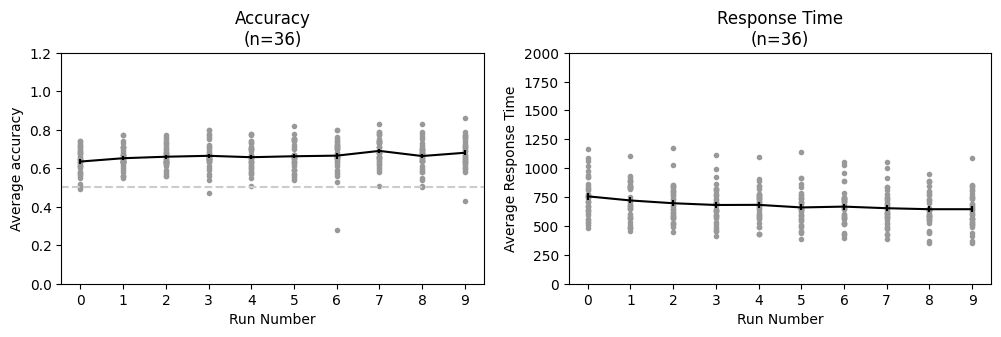

In [5]:
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
plot_vals = acc_by_run

n_runs = plot_vals.shape[1]
meanvals = np.mean(plot_vals, axis=0)
semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

for si in range(n_subjects):
    plt.plot(np.arange(n_runs), plot_vals[si,:],'.',color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(len(meanvals)), meanvals, semvals, color='k')
plt.xticks(np.arange(n_runs))
plt.xlabel('Run Number')
plt.ylabel('Average accuracy')
plt.axhline(0.50, color=[0.8, 0.8, 0.8], linestyle='--')
plt.ylim([0.0, 1.2])

plt.title('Accuracy\n(n=%d)'%n_subjects)


plt.subplot(1,2,2)

plot_vals = rt_by_run

meanvals = np.mean(plot_vals, axis=0)
semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

for si in range(n_subjects):
    plt.plot(np.arange(n_runs), plot_vals[si,:],'.',color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(len(meanvals)), meanvals, semvals, color='k')
plt.xticks(np.arange(n_runs))
plt.xlabel('Run Number')
plt.ylabel('Average Response Time')
ylims = [0, 2000]
plt.ylim(ylims)

plt.title('Response Time\n(n=%d)'%n_subjects)

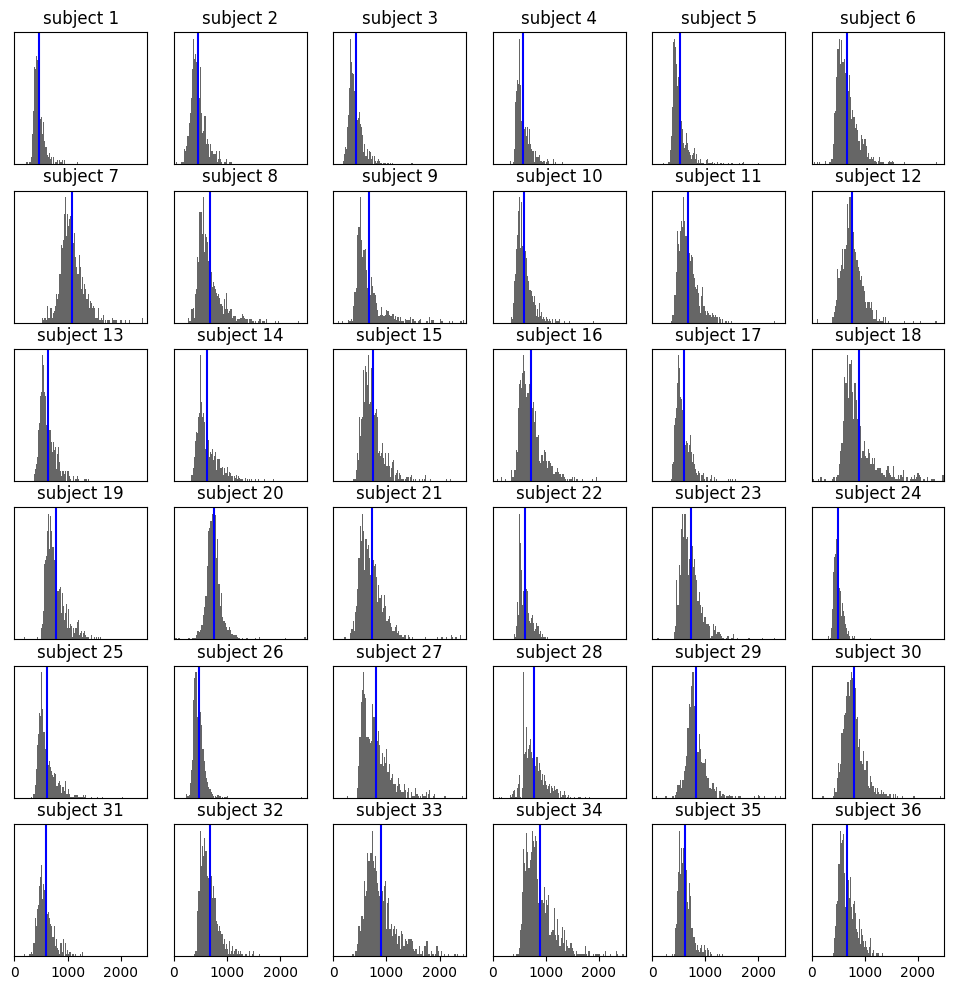

In [6]:
plt.figure(figsize=(12,12))
npy = int(np.ceil(np.sqrt(n_subjects)))
npx = int(np.ceil(n_subjects/npy))
xlims = [0, 500 + 2000]

for si,ss in enumerate(subjects):

    plt.subplot(npx, npy, si+1)
    
    rts = np.array(trial_data_all['rt'])[trial_data_all['subject']==ss]
    
    rts = rts[~np.isnan(rts)]
    
    assert(np.all(rts<=2500))
    
    plt.hist(rts,100, color=[0.4, 0.4, 0.4]);
    
    plt.title('subject %d'%ss)
    
    plt.xlim(xlims)
    if si<((npx-1)*(npy)):
        plt.xticks([])
    plt.yticks([])
    
    plt.axvline(np.mean(rts), color='b')

#### Plotting params

In [7]:
cue_level_colors = np.array([[130, 181, 216], [44,92,168]])/255
point_types = ['o','x']
markersize = 4;
xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

#### Run stats on the d' values (combine all subjects/all image sets)

In [8]:
vals = dprime_by_condition

print('\nAll subjects:')
print(vals.shape)

aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

print(aov_table)

# then pairwise t-tests (fine vs coarse)
result = scipy.stats.ttest_rel(vals[:,0,:], vals[:,1,:], axis=0, alternative='two-sided')
tvals = result.statistic
pvals = result.pvalue

df = pd.DataFrame(index=image_type_names)
df['t (basic-super)'] = tvals.round(4)
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr

df


All subjects:
(36, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond              56.395099     1.0    35.0  8.504873e-09
image_type       197.116288     4.0   140.0  1.848119e-56
cond:image_type    8.089092     4.0   140.0  6.753536e-06


,t (basic-super),p
pool1,0.1529,8.793564e-01
pool2,-3.0259,5.781492e-03
pool3,-5.5335,7.958395e-06
pool4,-9.2773,2.906500e-10
orig,-4.0792,4.135581e-04


#### Plot d' values

Text(0.5, 1.0, 'All subjects (n=36)')

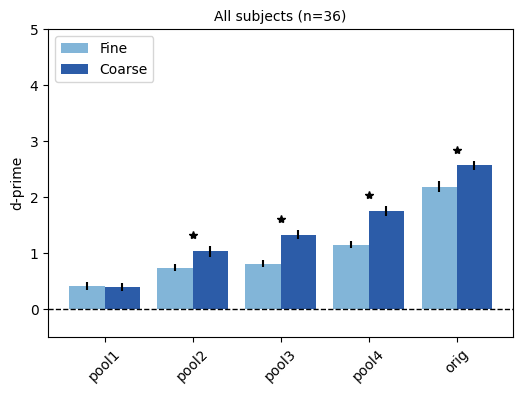

In [9]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = dprime_by_condition

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    if pvals_fdr[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
        plt.plot(ii, height, '*', color='k')

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)


plt.axhline(0.0, color='k',
            # color=[0.8, 0.8, 0.8],
            linestyle='--', linewidth=1)

plt.ylim([-.5, 5.0])
# assert(np.all(vals<5.0))
# assert(np.all(vals>-0.5))

ax.legend(lh, cue_level_names, loc='upper left')

plt.ylabel('d-prime')

plt.title('All subjects (n=%d)'%(n_subs_plot))

#### Check if d' is above chance for each condition

In [13]:
result = scipy.stats.ttest_1samp(dprime_by_condition, popmean = 0, axis=0, alternative = 'greater')
tvals = result.statistic
pvals = result.pvalue
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
print(tvals)
print(pvals_fdr.round(6))
np.all(pvals_fdr<0.01)

[[ 5.55988207 11.5748392  12.73662592 17.55468855 20.86147531]
 [ 5.259045   11.11480495 15.54328563 20.57665826 32.73416931]]
[[2.e-06 0.e+00 0.e+00 0.e+00 0.e+00]
 [4.e-06 0.e+00 0.e+00 0.e+00 0.e+00]]


True

#### pairwise comparisons across image types

In [14]:
pairs_test = list(itertools.combinations(np.arange(5),2))
n_pairs = len(pairs_test)
pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]

tvals = np.zeros((n_pairs))
pvals = np.zeros((n_pairs))

df = pd.DataFrame(index=pair_names)

# averaging across basic/super conds here
vals = np.mean(dprime_by_condition, axis=1)

for pi, pair in enumerate(pairs_test):

    vals1 = vals[:,pair[0]]
    vals2 = vals[:,pair[1]]

    result = scipy.stats.ttest_rel(vals1, vals2, axis=0, alternative='two-sided')
    t = result.statistic
    p = result.pvalue
    # p, t = stats_utils.paired_ttest_nonpar(vals1, vals2, n_iter=10000, rndseed=123434+pi)

    tvals[pi] = t
    pvals[pi] = p

df['t'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr

df   

,t,p
pool1 vs pool2,-7.5365,1.123358e-08
pool1 vs pool3,-8.5373,7.459712e-10
pool1 vs pool4,-12.1423,8.377321e-14
pool1 vs orig,-21.4251,1.052709e-20
pool2 vs pool3,-2.8950,6.490578e-03
pool2 vs pool4,-7.0196,4.505320e-08
pool2 vs orig,-19.4950,1.117264e-19
pool3 vs pool4,-5.7372,1.904969e-06
pool3 vs orig,-17.7011,1.613442e-18
pool4 vs orig,-16.7405,6.977799e-18


#### Analyze d' values: separating out the two image sets

In [15]:
for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = dprime_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

    print(aov_table)


tvals = np.zeros((2,5))
pvals = np.zeros((2,5))

df = pd.DataFrame(index=image_type_names)

for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = dprime_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)

    result = scipy.stats.ttest_rel(vals[:,0,:], vals[:,1,:], axis=0, alternative='two-sided')
    tvals[cbi,:] = result.statistic
    pvals[cbi,:] = result.pvalue
    
    # for ii in range(n_image_types):
        
    #     p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii], n_iter=10000, rndseed=566566+ii)
        
    #     tvals[cbi, ii] = t
    #     pvals[cbi, ii] = p
        
# fdr correcting all the values together
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cbi, cb in enumerate([1,2]):
    
    df['Set %d: t'%cb] = tvals[cbi,:].round(4)
    df['Set %d: p'%cb] = pvals_fdr[cbi,:]
    

df


Image set 1:
(18, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond              22.351132     1.0    17.0  1.944432e-04
image_type       127.330743     4.0    68.0  8.097640e-31
cond:image_type    4.731764     4.0    68.0  1.988235e-03

Image set 2:
(18, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond             38.728607     1.0    17.0  9.267117e-06
image_type       76.267566     4.0    68.0  2.107928e-24
cond:image_type   4.694343     4.0    68.0  2.096709e-03

Image set 1:
(18, 2, 5)

Image set 2:
(18, 2, 5)


,Set 1: t,Set 1: p,Set 2: t,Set 2: p
pool1,0.2486,0.896287,0.0013,0.998943
pool2,-0.3709,0.894082,-4.1575,0.001649
pool3,-3.0250,0.012726,-5.4924,0.000132
pool4,-7.5426,0.000008,-6.0946,0.000060
orig,-2.4704,0.034828,-3.2558,0.009307


#### Plot d' values, each image set

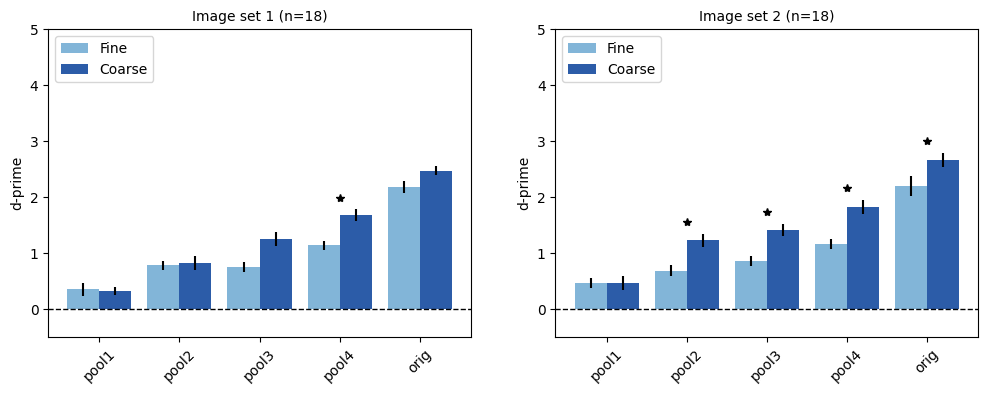

In [16]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(12,4))
    
for cbi, cb in enumerate([1,2]):

    ax = plt.subplot(1,2,cb)
    
    vals = dprime_by_condition[subject_cb==cbi,:,:]
    
    n_subs_plot = vals.shape[0]
        
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
    
    lh = []
    
    for ii in range(n_image_types):
        
        for cc, cue in enumerate(cue_level_names):
        
            h = plt.bar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                            color = cue_level_colors[cc,:], width=barwidth)
            
            plt.errorbar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                             semvals[cc,ii], \
                            color = 'k',
                            linestyle='none')
        
            lh.append(h)
    
        if pvals_fdr[cbi, ii]<0.01:
            height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
            plt.plot(ii, height, '*', color='k')
    
        
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)
    
    plt.axhline(0.0, color='k',
            # color=[0.8, 0.8, 0.8],
            linestyle='--', linewidth=1)

    ax.legend(lh, cue_level_names, loc='upper left')
    
    plt.ylabel('d-prime')
    
    plt.ylim([-.5, 5.0])
    # assert(np.all(vals<5.0))
    # assert(np.all(vals>-0.5))
    
    plt.title('Image set %d (n=%d)'%(cb, n_subs_plot))

#### Check if all d' values are above chance

In [17]:
for cbi, cb in enumerate([1,2]):
    
    vals = dprime_by_condition[subject_cb==cbi,:,:]
        
    result = scipy.stats.ttest_1samp(vals, popmean = 0, axis=0, alternative = 'greater')
    tvals = result.statistic
    pvals = result.pvalue
    _, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

    print('Set %d (n=%d)'%(cb, vals.shape[0]))
    print(tvals)
    print(pvals_fdr.round(6))
    print(np.all(pvals_fdr<0.01))

Set 1 (n=18)
[[ 3.09587536  9.844293    8.58408141 12.90543073 20.10904824]
 [ 4.5238367   6.47392956  9.73988985 15.51812203 29.87956837]]
[[3.281e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.670e-04 4.000e-06 0.000e+00 0.000e+00 0.000e+00]]
True
Set 2 (n=18)
[[ 4.90771729  6.86705069  9.34783557 11.68955086 11.96851681]
 [ 3.53459106 10.32716559 12.42996898 13.76327778 20.26452948]]
[[7.400e-05 2.000e-06 0.000e+00 0.000e+00 0.000e+00]
 [1.273e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00]]
True


#### Analyze RTs

In [18]:
vals = rt_by_condition

print('\nAll subjects:')
print(vals.shape)

aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

print(aov_table)

# then pairwise t-tests (fine vs coarse)
result = scipy.stats.ttest_rel(vals[:,0,:], vals[:,1,:], axis=0, alternative='two-sided')
t = result.statistic
p = result.pvalue

df = pd.DataFrame(index=image_type_names)
df['t (basic-super)'] = t.round(4)
_, pvals_fdr = stats_utils.fdr_keepshape(p, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr
df


All subjects:
(36, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond              2.831959     1.0    35.0  1.013070e-01
image_type       41.700511     4.0   140.0  5.502885e-23
cond:image_type   6.299565     4.0   140.0  1.086234e-04


,t (basic-super),p
pool1,-2.5397,0.039226
pool2,0.3440,0.732937
pool3,0.4853,0.732937
pool4,1.1545,0.426838
orig,-3.1934,0.014853


#### plot RTs, all subjects

Text(0.5, 1.0, 'All subjects (n=36)')

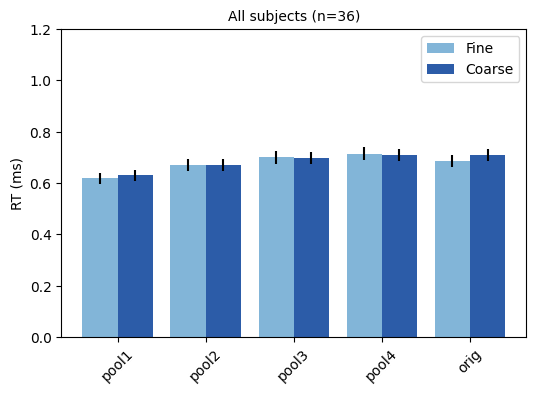

In [20]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = rt_by_condition/1000

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    if pvals_fdr[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+0.05
        plt.plot(ii, height, '*', color='k')

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

# plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

ax.legend(lh, cue_level_names, loc='upper right')

plt.ylabel('RT (ms)')

plt.ylim([0, 1.200])

plt.title('All subjects (n=%d)'%(n_subs_plot))

#### pairwise comparisons across image types

In [21]:

pairs_test = list(itertools.combinations(np.arange(5),2))
n_pairs = len(pairs_test)
pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]

tvals = np.zeros((n_pairs))
pvals = np.zeros((n_pairs))

df = pd.DataFrame(index=pair_names)


# averaging across basic/super conds here
vals = np.mean(rt_by_condition, axis=1)

for pi, pair in enumerate(pairs_test):

    vals1 = vals[:,pair[0]]
    vals2 = vals[:,pair[1]]

    result = scipy.stats.ttest_rel(vals1, vals2, axis=0, alternative='two-sided')
    t = result.statistic
    p = result.pvalue
    # p, t = stats_utils.paired_ttest_nonpar(vals1, vals2, n_iter=10000, rndseed=132433+pi)

    tvals[pi] = t
    pvals[pi] = p

df['t'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr


df   

,t,p
pool1 vs pool2,-9.5973,8.191799e-11
pool1 vs pool3,-9.7817,7.527445e-11
pool1 vs pool4,-10.0082,7.527445e-11
pool1 vs orig,-6.5147,2.717557e-07
pool2 vs pool3,-6.6760,2.009677e-07
pool2 vs pool4,-6.7510,2.006601e-07
pool2 vs orig,-2.8553,8.978875e-03
pool3 vs pool4,-3.3782,2.574561e-03
pool3 vs orig,0.0768,9.392266e-01
pool4 vs orig,1.9539,6.527370e-02


#### RTs: separate out the two image sets

In [22]:
for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = rt_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

    print(aov_table)


tvals = np.zeros((2,5))
pvals = np.zeros((2,5))

df = pd.DataFrame(index=image_type_names)

for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = rt_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)

    result = scipy.stats.ttest_rel(vals[:,0,:], vals[:,1,:], axis=0, alternative='two-sided')
    tvals[cbi,:] = result.statistic
    pvals[cbi,:] = result.pvalue
    
    # for ii in range(n_image_types):
        
    #     p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii], n_iter=10000, rndseed=566566+ii)
        
    #     tvals[cbi, ii] = t
    #     pvals[cbi, ii] = p
        
# fdr correcting all the values together
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cbi, cb in enumerate([1,2]):
    
    df['Set %d: t'%cb] = tvals[cbi,:].round(4)
    df['Set %d: p'%cb] = pvals_fdr[cbi,:]
    

df


Image set 1:
(18, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond              2.391924     1.0    17.0  1.403761e-01
image_type       26.388431     4.0    68.0  3.166489e-13
cond:image_type   6.425240     4.0    68.0  1.905144e-04

Image set 2:
(18, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond              0.680229     1.0    17.0  4.209303e-01
image_type       16.864119     4.0    68.0  1.196009e-09
cond:image_type   1.734710     4.0    68.0  1.524485e-01

Image set 1:
(18, 2, 5)

Image set 2:
(18, 2, 5)


,Set 1: t,Set 1: p,Set 2: t,Set 2: p
pool1,-1.6856,0.367106,-1.8551,0.367106
pool2,0.6284,0.672599,-0.3248,0.832553
pool3,-0.1899,0.851667,0.8560,0.672599
pool4,0.9850,0.672599,0.6947,0.672599
orig,-3.8605,0.012548,-1.2306,0.588079


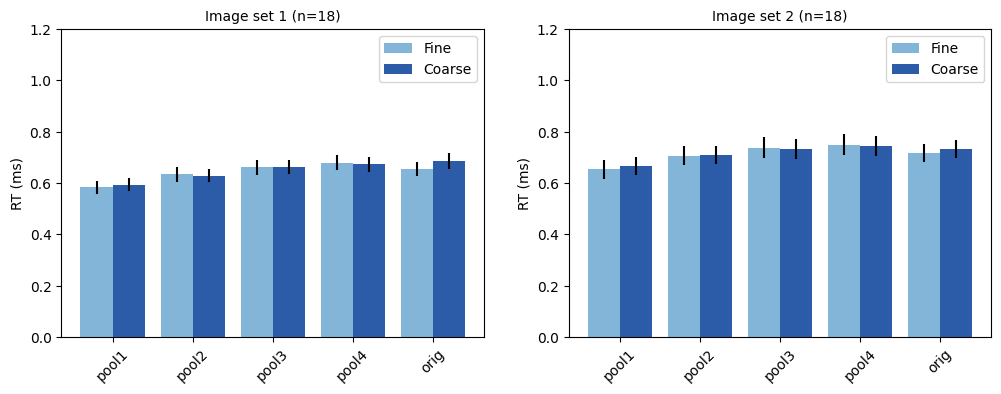

In [23]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(12,4))
    
for cbi, cb in enumerate([1,2]):

    ax = plt.subplot(1,2,cb)
    
    vals = rt_by_condition[subject_cb==cbi,:,:] / 1000
    
    n_subs_plot = vals.shape[0]
        
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
    
    lh = []
    
    for ii in range(n_image_types):
        
        for cc, cue in enumerate(cue_level_names):
        
            h = plt.bar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                            color = cue_level_colors[cc,:], width=barwidth)
            
            plt.errorbar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                             semvals[cc,ii], \
                            color = 'k',
                            linestyle='none')
        
            lh.append(h)
    
        if pvals_fdr[cbi, ii]<0.01:
            height = np.max(meanvals[:,ii]+semvals[:,ii])+0.05
            plt.plot(ii, height, '*', color='k')
    
        
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)
    
        
        
    
    # plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')
    
    ax.legend(lh, cue_level_names, loc='upper right')
    
    plt.ylabel('RT (ms)')
    
    plt.ylim([0, 1.200])
    
    plt.title('Image set %d (n=%d)'%(cb, n_subs_plot))

#### Response bias

Text(0.5, 1.0, 'All subjects (n=36)')

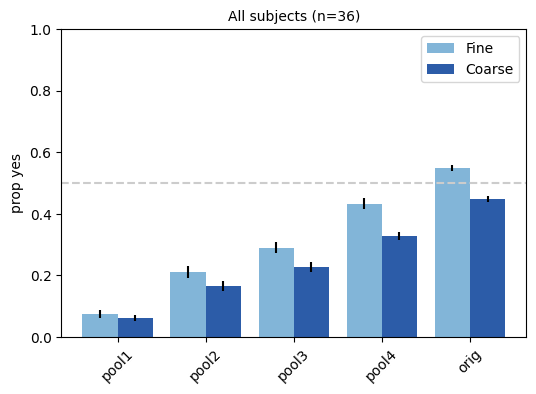

In [24]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = propyes_by_condition

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

ax.legend(lh, cue_level_names, loc='upper right')

plt.ylabel('prop yes')

plt.ylim([0, 1.0])

plt.title('All subjects (n=%d)'%(n_subs_plot))

#### Natural versus artificial

In [38]:
tvals = np.zeros((n_image_types, n_cue_levels))
pvals = np.zeros((n_image_types, n_cue_levels))

vals = dprime_by_nat;

df = pd.DataFrame(index=image_type_names)

result = scipy.stats.ttest_rel(vals[:,:,:,0], vals[:,:,:,1], axis=0, alternative='two-sided')
# want [image types x cue levels]
tvals[:,:] = result.statistic.T
pvals[:,:] = result.pvalue.T

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cc, cue in enumerate(cue_level_names):

    df['%s: t'%(cue_level_names[cc])] = tvals[:,cc].round(4)

    df['%s: p'%(cue_level_names[cc])] = pvals_fdr[:,cc]

# print(df)
df

,Fine: t,Fine: p,Coarse: t,Coarse: p
pool1,0.7195,0.595743,-3.2019,0.007273
pool2,0.4568,0.722935,-3.2013,0.007273
pool3,-0.2260,0.822484,-3.7858,0.002887
pool4,0.8441,0.577602,-6.3508,0.000003
orig,2.6798,0.022304,-2.2790,0.048125


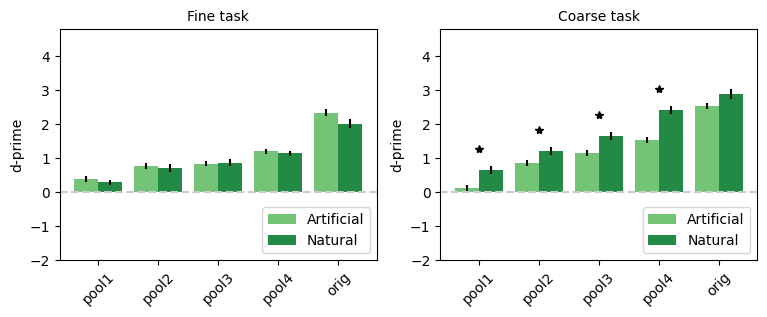

In [39]:
plot_utils.set_all_font_sizes(10)


nat_colors = cm.Greens(np.linspace(0,1,5))[[2,3],:]
n_kinds = 2
kind_names = ['Artificial','Natural']

plt.figure(figsize=(9,3))

    
for cc in [0,1]:
    
    ax = plt.subplot(1,2,cc+1)

    vals = dprime_by_nat[:,cc,:,:]
    n_subs_plot = vals.shape[0]

    plot_vals = vals;
    meanvals = np.mean(plot_vals, axis=0)
    semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

    lh = []
    
    for kk in range(n_kinds):

        # for si in range(n_subs_plot):

        h = plt.bar(np.arange(n_image_types)+xjitters[kk], \
                 meanvals[:,kk], color=nat_colors[kk,:], width=barwidth)
        
        plt.errorbar(np.arange(n_image_types)+xjitters[kk], \
                                 meanvals[:,kk], \
                                 semvals[:,kk], \
                                color = 'k', linestyle='none')
        lh.append(h)

    for ii in range(n_image_types):
        if pvals_fdr[ii,cc]<0.01:
            height = np.max(meanvals[ii,:]+semvals[ii,:])+0.50
            plt.plot(ii, height, '*', color='k')

    
    # plt.title('image set %d'%(cb))
    
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)


    plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

    ax.legend(lh, kind_names, loc='lower right')

    plt.ylabel('d-prime')

    plt.ylim([-2, 4.8])
        
    plt.title('%s task'%(cue_level_names[cc]))

In [40]:
vals = dprime_by_nat
dim_names = ['cond','image_type','naturalness']
stats_utils.rmanova_3way(vals, dim_names)

,F Value,Num DF,Den DF,Pr > F
cond,89.433769,1.0,35.0,3.579394e-11
image_type,245.272069,4.0,140.0,3.534877e-62
naturalness,17.979622,1.0,35.0,1.549617e-04
cond:image_type,13.716133,4.0,140.0,1.835771e-09
cond:naturalness,87.183573,1.0,35.0,4.942678e-11
image_type:naturalness,2.627063,4.0,140.0,3.712414e-02
cond:image_type:naturalness,1.304041,4.0,140.0,2.714978e-01


#### Check if all d' values are above chance
In this experiment, some of these are actually not different from zero

In [36]:
df = pd.DataFrame(index=image_type_names)

vals = dprime_by_nat

result = scipy.stats.ttest_1samp(vals, popmean = 0, axis=0, alternative = 'greater')
tvals = result.statistic
pvals = result.pvalue
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

print(np.all(pvals_fdr<0.01))

for cc in range(2):
    print(tvals[cc,:,:])
    for kk in range(2):
        df['%s, %s: p<0.01'%(cue_level_names[cc], kind_names[kk])] = \
            pvals_fdr[cc,:,kk]<0.01

df

False
[[ 4.19150067  3.71364733]
 [ 9.20178665  6.71851259]
 [11.73956137  8.65614854]
 [16.81997685 13.75003593]
 [22.44307744 14.74734325]]
[[ 1.36731135  5.7400135 ]
 [ 8.88754232 11.08883591]
 [12.47488148 14.33203588]
 [16.11482288 19.16251423]
 [32.39674209 20.03281298]]


,"Fine, Artificial: p<0.01","Fine, Natural: p<0.01","Coarse, Artificial: p<0.01","Coarse, Natural: p<0.01"
pool1,True,True,False,True
pool2,True,True,True,True
pool3,True,True,True,True
pool4,True,True,True,True
orig,True,True,True,True


#### Natural versus artificial: within image sets

In [29]:
tvals = np.zeros((n_image_types, n_cue_levels, 2))
pvals = np.zeros((n_image_types, n_cue_levels, 2))

dvals = dprime_by_nat;

df = pd.DataFrame(index=image_type_names)

for cbi, cb in enumerate([1,2]):

    subjects_plot = (subject_cb==cbi) 

    vals = dvals[subjects_plot,:,:,:]

    result = scipy.stats.ttest_rel(vals[:,:,:,0], vals[:,:,:,1], axis=0, alternative='two-sided')
    # want [image types x cue levels]
    tvals[:,:,cbi] = result.statistic.T
    pvals[:,:,cbi] = result.pvalue.T
  
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cc, cue in enumerate(cue_level_names):

    for cbi, cb in enumerate([1,2]):
    
        df['Set %d, %s: t'%(cb,cue_level_names[cc])] = tvals[:,cc,cbi].round(4)
    
        df['Set %d, %s: p'%(cb,cue_level_names[cc])] = pvals_fdr[:,cc,cbi]

# print(df)
df

,"Set 1, Fine: t","Set 1, Fine: p","Set 2, Fine: t","Set 2, Fine: p","Set 1, Coarse: t","Set 1, Coarse: p","Set 2, Coarse: t","Set 2, Coarse: p"
pool1,0.0430,0.966193,0.8859,0.517367,-0.7457,0.582562,-3.8161,0.009212
pool2,-1.6905,0.218363,1.9110,0.162265,-3.0058,0.026517,-1.5144,0.269643
pool3,-1.0015,0.472293,1.1399,0.415564,-2.0339,0.144682,-3.6046,0.010935
pool4,0.1072,0.964090,1.1987,0.411835,-8.2150,0.000005,-2.7076,0.042674
orig,-0.3711,0.794615,3.8367,0.009212,-3.3869,0.014024,-0.4137,0.794615


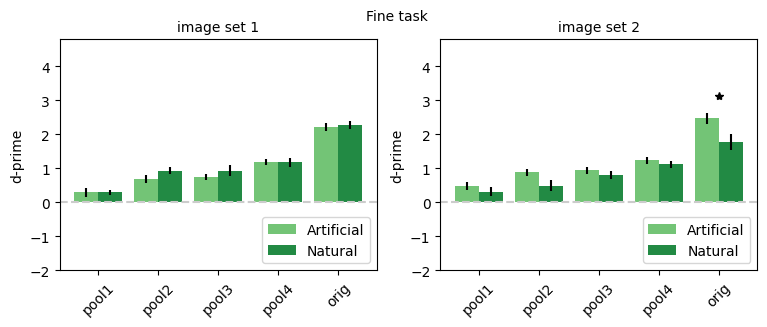

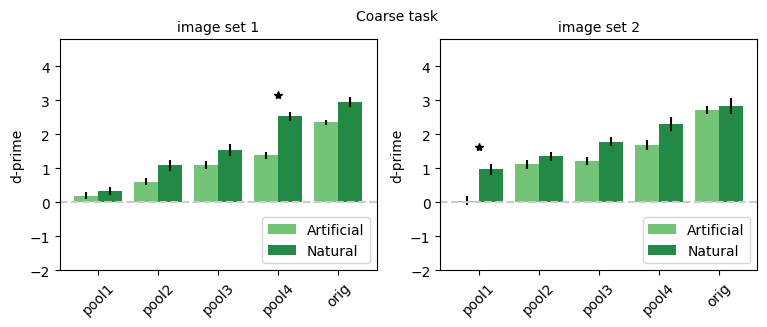

In [30]:
plot_utils.set_all_font_sizes(10)


nat_colors = cm.Greens(np.linspace(0,1,5))[[2,3],:]
n_kinds = 2
kind_names = ['Artificial','Natural']

for cc in [0,1]:
    
    plt.figure(figsize=(9,3))

    for cbi, cb in enumerate([1,2]):
    
        ax = plt.subplot(1,2,cb)
        
        subjects_plot = (subject_cb==cbi) 
        n_subs_plot = np.sum(subjects_plot)
        vals = dprime_by_nat[subjects_plot,cc,:,:]
        
        plot_vals = vals;
        meanvals = np.mean(plot_vals, axis=0)
        semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

        lh = []
        
        for kk in range(n_kinds):

            # for si in range(n_subs_plot):

            h = plt.bar(np.arange(n_image_types)+xjitters[kk], \
                     meanvals[:,kk], color=nat_colors[kk,:], width=barwidth)
            
            plt.errorbar(np.arange(n_image_types)+xjitters[kk], \
                                     meanvals[:,kk], \
                                     semvals[:,kk], \
                                    color = 'k', linestyle='none')
            lh.append(h)

        for ii in range(n_image_types):
            if pvals_fdr[ii,cc,cbi]<0.01:
                height = np.max(meanvals[ii,:]+semvals[ii,:])+0.50
                plt.plot(ii, height, '*', color='k')

        
        plt.title('image set %d'%(cb))
        
        plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)


        plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

        ax.legend(lh, kind_names, loc='lower right')

        plt.ylabel('d-prime')

        plt.ylim([-2, 4.8])
        
    plt.suptitle('%s task'%(cue_level_names[cc]))

#### Check if all d' values are above chance
In this experiment, some of these are actually not different from zero

In [27]:
df = pd.DataFrame(index=image_type_names)

cbi = 0; cb = 1;
# for cbi, cb in enumerate([1,2]):

vals = dprime_by_nat[subject_cb==cbi,:,:]
    
result = scipy.stats.ttest_1samp(vals, popmean = 0, axis=0, alternative = 'greater')
tvals = result.statistic
pvals = result.pvalue
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

print('Set %d (n=%d)'%(cb, vals.shape[0]))
# print(tvals)
print(np.all(pvals_fdr<0.01))

for cc in range(2):
    print(tvals[cc,:,:])
    for kk in range(2):
        df['Set %d, %s, %s: p<0.01'%(cb, cue_level_names[cc], kind_names[kk])] = \
            pvals_fdr[cc,:,kk]<0.01

df

Set 1 (n=18)
False
[[ 2.09934894  3.16427596]
 [ 5.475669    8.58943101]
 [ 7.80767357  5.65217485]
 [12.36012723  9.56460754]
 [18.86467569 18.95376703]]
[[ 1.88611126  2.88091152]
 [ 5.2505346   6.24895606]
 [ 8.0974478   8.1055105 ]
 [12.09768232 17.90217086]
 [26.78551864 18.53660481]]


,"Set 1, Fine, Artificial: p<0.01","Set 1, Fine, Natural: p<0.01","Set 1, Coarse, Artificial: p<0.01","Set 1, Coarse, Natural: p<0.01"
pool1,False,True,False,True
pool2,True,True,True,True
pool3,True,True,True,True
pool4,True,True,True,True
orig,True,True,True,True


In [42]:
df = pd.DataFrame(index=image_type_names)

cbi = 1; cb = 2;
# for cbi, cb in enumerate([1,2]):

vals = dprime_by_nat[subject_cb==cbi,:,:]
    
result = scipy.stats.ttest_1samp(vals, popmean = 0, axis=0, alternative = 'greater')
tvals = result.statistic
pvals = result.pvalue
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

print('Set %d (n=%d)'%(cb, vals.shape[0]))
# print(tvals)
print(np.all(pvals_fdr<0.01))

for cc in range(2):
    print(tvals[cc,:,:])
    for kk in range(2):
        df['Set %d, %s, %s: p<0.01'%(cb, cue_level_names[cc], kind_names[kk])] = \
            pvals_fdr[cc,:,kk]<0.01

df

Set 2 (n=18)
False
[[ 3.9706593   2.28128027]
 [ 7.72674247  2.898118  ]
 [ 8.92683871  6.81963046]
 [11.24606585  9.64286194]
 [14.43964727  7.50816205]]
[[ 0.33413678  5.81295984]
 [ 8.40402451 10.22658389]
 [ 9.43705683 13.47517935]
 [11.49177767 10.98284804]
 [23.51641292 11.55611713]]


,"Set 2, Fine, Artificial: p<0.01","Set 2, Fine, Natural: p<0.01","Set 2, Coarse, Artificial: p<0.01","Set 2, Coarse, Natural: p<0.01"
pool1,True,False,False,True
pool2,True,True,True,True
pool3,True,True,True,True
pool4,True,True,True,True
orig,True,True,True,True
